# 数据集处理
## 总体流程
- pipeline：
    - 加载数据，对full_data进行基本清洗\
    选择数据的前5%作为
      --> train_data_cleaned
    - 使用清洗数据 train_data_cleaned 进行聚类，生成标签 labels = {0, 1}
    - 使用数据训练一个分类器，对full_data 进行分类
    - 保留 label == 1
    - 抽查数据，检查是否完成清洗

In [31]:
import re 
import numpy as np
import pandas as pd
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

## 1.加载数据进行基本清洗

In [2]:
ds = load_dataset("parquet", data_files = "./dataset/wudao/*.parquet", split="train",)
size_need_data = int(len(ds) * 0.05)
ds

Dataset({
    features: ['text'],
    num_rows: 354798
})

In [3]:
def clean_text(text):
    if not text or not isinstance(text, str):
        return False
    
    # 1. 去掉HTML标签（增强版）
    text = re.sub(r'<[^>]+>', '', text)  # 更稳健的HTML标签匹配
    
    # 2. 去掉空文本（增强检查）
    if not text.strip():
        return False
    
    # 3. 去掉各种类型的电话号码
    text = re.sub(r'\b\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}\b', '', text)  # 带分隔符的电话
    text = re.sub(r'\b\d{11}\b', '', text)  # 11位手机号
    text = re.sub(r'\b\d{4}[-\.\s]??\d{3}[-\.\s]??\d{4}\b', '', text)  # 带区号的电话
    
    # 4. 扩展广告语和推广内容识别
    ad_patterns = [
        '关注公众号', '扫码.*获取', '添加微信', '点击下方链接',
        '详情请访问', '领取优惠券', '限时折扣', '立即购买', '了解更多',
        '欢迎转载', '版权声明', '免责声明', '文章来源', '发布于',
        'tel', '电话', '联系电话', '热线', '企鹅', 'qq', 'q号'
    ]
    for pattern in ad_patterns:
        text = re.sub(pattern, '', text)
    
    # 5. 处理URL和电子邮件
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    # 6. 扩展表情符号和特殊字符处理
    text = re.sub(r'[\U00010000-\U0010FFFF]', '', text)  # 高位Unicode表情
    text = re.sub(r'[\u2000-\u2FFF]', '', text)  # 扩展标点、符号
    text = re.sub(r'[\u3000-\u303F]', '', text)  # 中文标点符号（可选）
    text = re.sub(r'[\[\]{}<>#*★◇§♡♥♪♬▶▼▪◆●¡⭐]', '', text)  # 更多特殊符号
    
    # 7. 处理重复标点和无意义字符序列
    text = re.sub(r'[!?。，]{2,}', '.', text)  # 多个重复标点替换为单个
    text = re.sub(r'[\.]{2,}', '.', text)  # 多个句点替换为单个
    text = re.sub(r'[\s]+', ' ', text)  # 多个空白字符替换为单个空格
    text = re.sub(r'\s+', ' ', text).strip() # 替换重复的空格
    
    # 8. 处理无意义短文本
    # 如果清洗后文本太短，可能是无意义内容
    cleaned_text = text.strip()
    if len(cleaned_text) < 64:  # 可根据实际调整阈值
        return False
    
    return cleaned_text

# 测试
raw_text = "关注公众号ABC获取资料😄，手机号13812345678，网页链接<a href='x'>链接</a> ★中国共产党万宁市委员会统一战线工作部\n中国共产党万宁市委员会统一战线工作部是中国共产党万宁市委员会工作部门。"
cleaned_text = clean_text(raw_text)
print(cleaned_text)


ABC获取资料，手机号13812345678，网页链接链接 中国共产党万宁市委员会统一战线工作部 中国共产党万宁市委员会统一战线工作部是中国共产党万宁市委员会工作部门


In [4]:
for i in range(2):
    ds_clean = ds.filter(lambda x: clean_text(x["text"]))
print(ds_clean)

Dataset({
    features: ['text'],
    num_rows: 354228
})


In [5]:
ds_select = ds_clean.shuffle(seed=42).select(range(size_need_data))
ds_select, ds_clean, ds

(Dataset({
     features: ['text'],
     num_rows: 17739
 }),
 Dataset({
     features: ['text'],
     num_rows: 354228
 }),
 Dataset({
     features: ['text'],
     num_rows: 354798
 }))

In [6]:
ds_select["text"][10:12]

['毛缘扇虾\n毛缘扇虾系甲壳纲 十足目 龙虾总科 蝉虾科（Scyllaridae）的海洋虾类，俗称”虾排。广泛分布于印度--西太平洋热带、亚热带海域，中国东海、南海偶见，为食用经济物种。毛缘扇虾头胸甲极扁平，体被褐红色硬甲，眼睛位于头胸甲的前方，侧缘锯齿状，具绒毛；腹部比较短小，具分节；尾部呈薄扇状；腹足五对，无钳，不发达，只能缓慢在海底做匍匐爬行，偶能利用其腹节的屈伸做短距离游动。本词条由“科普中国”科学百科词条编写与应用工作项目 审核 。 毛缘扇虾简介 毛缘扇虾（Ibacus novemdentatus）俗名：琵琶虾。栖息在37至400米水深之 毛缘扇虾 沙泥底质的大陆棚平坦海域，平时潜伏在海底的浅砂中。身体极为扁平，背面颇为平滑或稍具陷点。长可达19公分，头胸甲具鳃脊及颈部缺刻深，后侧缘裂为7至8个大齿，眼窝位于头胸甲前缘，第二触角宽扁且无触角鞭，第五腹节后缘具中央刺，侧甲朝外。 [1] 毛缘扇虾形态特征 爬行甲壳类，头胸甲中间脊上有4个明显的突起，前侧齿简单，后侧缘具7至8 毛缘扇虾 齿。眼眶后部的缺刻小而浅。头胸甲前缘中间成1棘状突起。前额板的前缘呈1对三角形。各腹节侧甲呈刀形，尾节宽大于长。第3颚足长节膨大而成椭圆形。其腹面有8条横沟。雄性第5步足不成亚钳状。 [2] 身体呈淡黄褐色，背面参杂有红褐斑，头胸甲腹面及步足褐色和白色，卵为橘色。 毛缘扇虾头胸甲极扁平，体被褐红色硬甲，眼睛位于头胸甲的前方，侧缘锯齿状，具绒毛；腹部比较短小，具分节；尾部呈薄扇状；腹足五对，无钳，不发达，只能缓慢在海底做匍匐爬行，偶能利用其腹节的屈伸做短距离游动。 [3] 毛缘扇虾分布范围 毛缘扇虾系甲壳纲 十足目 龙虾总科 蝉虾科（Scyllaridae）的海洋虾类，广泛分布于印度--西太平洋热带、亚热带海域，中国东海、南海偶见，为食用经济物种。 [3] 毛缘扇虾营养价值 毛缘扇虾是一种营养丰富、汁鲜肉嫩的海味食品。其肉质含水分较多，肉味鲜甜嫩滑，淡而柔软，并且有一种特殊诱人的鲜味。每年春季是其产卵的季节，此时食用为最佳。肥壮的虾蛄脑部满是膏脂，肉质十分鲜嫩，味美可口，可惜壳多肉少。但其蛋白质含量高达20%，脂肪0.7%，以及维生素、肌苷酸、氨基丙酸(建议编者仔细查阅资料，丙氨酸是20种天然氨基酸之一，可作为营养成分，但是氨基丙酸，其结构和丙氨酸不同，这将导致它们的生化作用不

## 2.聚类分析
使用BERT进行向量化

In [7]:
from transformers import BertTokenizer, BertModel
import torch 

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')
model.eval()
device = "cuda"
if torch.cuda.is_available():
    model.to(device)

In [8]:

def bert_encode_batch(batch):
    inputs = tokenizer(batch['text'], padding=True, 
                       truncation=True, max_length=128, 
                       return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        # CLS 向量，每条文本对应一个 (768,)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return {"embeddings": embeddings}

In [9]:
ds_select_with_emb = ds_select.map(bert_encode_batch, 
                                   batched=True, batch_size=128) # 批量处理

data从huggingface格式转化为np格式

In [10]:
data_kmeans = np.array(ds_select_with_emb["embeddings"])
data_kmeans.shape, data_kmeans

((17739, 768),
 array([[ 1.24232304e+00,  2.67468933e-02, -7.55661051e-04, ...,
          1.83878951e-02,  3.31922323e-01, -1.22846335e-01],
        [ 1.84932396e-01,  2.82470524e-01, -4.54600304e-02, ...,
          4.88860011e-01,  7.09103167e-01, -5.70792973e-01],
        [-1.07354879e+00,  3.35593760e-01, -9.67406869e-01, ...,
          2.64202505e-01,  8.90082121e-01,  2.13372946e-01],
        ...,
        [ 1.06823385e-01, -6.79086089e-01, -1.00924170e+00, ...,
          7.62437761e-01,  1.41841441e-01,  1.69740766e-01],
        [ 7.84251928e-01, -6.75555706e-01, -9.36747551e-01, ...,
         -2.91870326e-01, -2.93687344e-01, -6.19381726e-01],
        [ 3.18266869e-01, -4.80955243e-02,  1.31061852e-01, ...,
         -4.29742724e-01, -3.98090892e-02, -6.36384547e-01]]))

随机抽样（0.05）确定分类簇

In [11]:

rng = np.random.default_rng(42)
idx = rng.choice(len(data_kmeans), 8000, replace=False)
data_test_k = data_kmeans[idx] 
data_test_k.shape, type(data_test_k)

((8000, 768), numpy.ndarray)

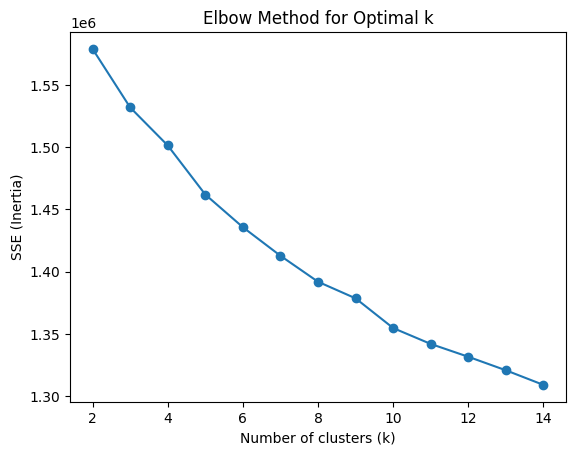

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_test_k)
    sse.append(kmeans.inertia_)

plt.plot(K_range, sse, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()

-  肘部法图（Elbow Method）
    - 横轴是聚类数 k，纵轴是误差平方和（ESS）    
    - 可以明显看到对于k=3， 附近下降速度明显减缓，形成一个“肘部”

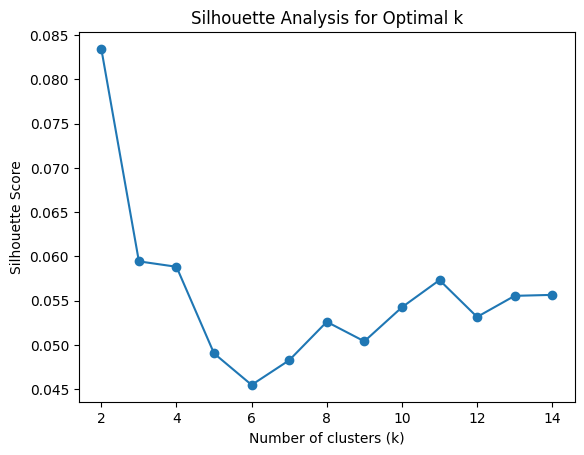

In [13]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_test_k)
    score = silhouette_score(data_test_k, labels)
    sil_scores.append(score)

plt.plot(K_range, sil_scores, 'o-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.show()

- 轮廓系数图（Silhouette Analysis）
    - 横轴是聚类数 k，纵轴是平均轮廓系数（Silhouette Score）
    - 以及在 k=3 时轮廓系数达到一个局部最大值。

**综合，k取3**

In [14]:
def cluster_with_kmeans(X, k, random_state=42):
    """
    使用 KMeans 进行聚类
    Args:
        X: numpy.ndarray, shape (n_samples, n_features) 文本向量
        k: int, 簇数
    Returns:
        labels: numpy.ndarray, 每个样本对应的簇标签
        model: 训练好的 KMeans 模型
    """
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = kmeans.fit_predict(X)
    return labels, kmeans

labels, kmeans =cluster_with_kmeans(data_kmeans,8)

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


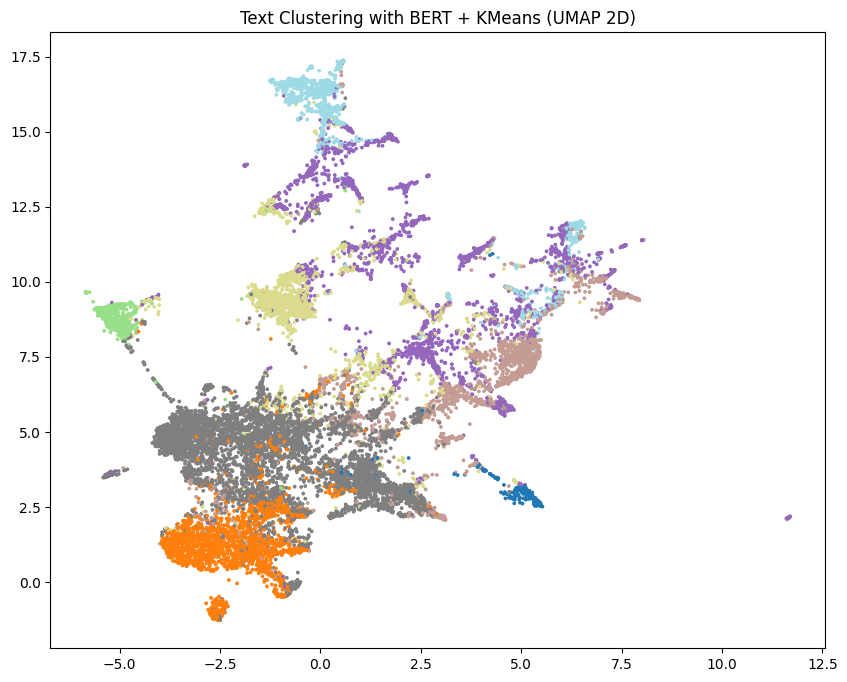

In [15]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42)

X_2d = reducer.fit_transform(data_kmeans)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab20", s=3)
plt.title("Text Clustering with BERT + KMeans (UMAP 2D)")
plt.show()

In [16]:
print("聚类标签：", kmeans.labels_)
print("聚类中心：", kmeans.cluster_centers_)
print("ESS（inertia）：", kmeans.inertia_)
print("迭代次数：", kmeans.n_iter_)

聚类标签： [5 5 3 ... 6 5 4]
聚类中心： [[-0.15719444  0.25907046 -1.19919704 ...  1.03764115  0.72343372
  -0.09372694]
 [ 0.42076272  0.22263536 -0.08104658 ...  0.26821939 -0.36265725
  -0.45133592]
 [ 0.73741194  0.13044909 -0.41309095 ... -0.61540278  0.31785344
   0.25852958]
 ...
 [ 0.54632521 -0.02388345 -0.34391157 ...  0.41530743  0.03547401
  -0.516992  ]
 [-0.0924365  -0.22962245 -0.57343767 ...  0.17693184 -0.06896683
  -0.1325839 ]
 [ 0.03517465 -0.02007456 -0.47540598 ...  0.45046666  0.26413471
  -0.08435557]]
ESS（inertia）： 3113718.7844585893
迭代次数： 47


In [17]:
data_kmeans.shape, len(kmeans.labels_), len(ds_select["text"]), 

((17739, 768), 17739, 17739)

In [18]:
type(ds_select["text"]), type(ds_select["text"][0:1])

(datasets.arrow_dataset.Column, list)

In [19]:
text = ds_select["text"]

df_kmeans = pd.DataFrame(
    {"text" : text,
    "labels" : kmeans.labels_}
)
df_kmeans.head()

,text,labels
0,破解了！钱枫发胖之谜终于在一夜之间真相大白！\n作为湖南卫视主持人中的一员钱枫可以说是看着《...,5
1,"夫妻关系:女人要是在外有了情人,就会出现几个""共性""\n导读:夫妻关系:女人要是在外有了情人...",5
2,毛家饭店(贵阳博爱路店)\n“毛家饭店”原处毛泽东同志故居对面，由曾受到毛主席亲切接见的汤瑞...,3
3,坦波莱顿阶\n（TempletonianStage）是澳大利亚中寒武统下部的一个阶，位于下寒...,3
4,莱昂·布鲁姆\n安德烈 莱昂·布鲁姆（André Léon Blum ，1872年4月9日–...,3


In [20]:
# for l in range(9):
#     print(df_kmeans[df_kmeans["labels"] == l])
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17739 entries, 0 to 17738
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17739 non-null  object
 1   labels  17739 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 208.0+ KB


## 3.训练模型

In [21]:
from sklearn.model_selection import train_test_split

# 转化为hugingface的dataframe
train_data, val_data = train_test_split(df_kmeans, test_size=0.1, random_state=42)
ds_bert = DatasetDict({
    "train" : Dataset.from_pandas(df_kmeans.reset_index(drop=True), split="train"),
    "valid" : Dataset.from_pandas(val_data.reset_index(drop=True), split="valid"),
})
type(ds_bert), ds_bert

(datasets.dataset_dict.DatasetDict,
 DatasetDict({
     train: Dataset({
         features: ['text', 'labels'],
         num_rows: 17739
     })
     valid: Dataset({
         features: ['text', 'labels'],
         num_rows: 1774
     })
 }))

In [22]:
# for k in range(8):
#     print(len(ds_bert["valid"].filter(lambda x: x["labels"] == k)), "\n", len(ds_bert["train"].filter(lambda x: x["labels"] == k)))

In [25]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
def tokenize(batch):
    return tokenizer(batch["text"], padding=False, truncation=True, max_length=512)

tokened_dataset = ds_bert.map(tokenize, batched=True)

Map:   0%|          | 0/17739 [00:00<?, ? examples/s]

Map:   0%|          | 0/1774 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=8)

training_args = TrainingArguments(
    output_dir="./model/classification/BERT_classifier_for_wudao",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./model/classification/logs",
    logging_first_step=True,
    logging_steps=4,
    save_steps=2000,
    report_to="tensorboard",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokened_dataset["train"],
    eval_dataset=tokened_dataset["valid"],
    data_collator=data_collator,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
trainer.train()

C:\Users\hhm18\miniconda3\envs\env_LLM\lib\site-packages\transformers\models\bert\modeling_bert.py:412: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,0.428200,0.335395
2,0.475800,0.121991
3,0.000800,0.043002


TrainOutput(global_step=6654, training_loss=0.35827829738422307, metrics={'train_runtime': 3110.3907, 'train_samples_per_second': 17.109, 'train_steps_per_second': 2.139, 'total_flos': 1.4002735341920256e+16, 'train_loss': 0.35827829738422307, 'epoch': 3.0})